# DACON 소설 작가 분류 AI 경진대회

# ▶▶▶ Library import

In [1]:
# ■■■■■■■■■■■■■■■■ Import library ■■■■■■■■■■■■■■■■
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
from gensim.models.keyedvectors import KeyedVectors
import fasttext
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional, Conv1D, GRU

# 1. Preprocessing

## 1-1. Data load

In [2]:
train = pd.read_csv('data/train.csv', encoding='utf-8')
test = pd.read_csv('data/test_x.csv', encoding='utf-8')
sample_submission = pd.read_csv('data/sample_submission.csv', encoding='utf-8')

In [3]:
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [4]:
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


In [5]:
sample_submission

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


## 1-2. Stopwords delete and Words alphabet lower

In [6]:
# ■■■■■■■■■■■■■■■■ Stopwords delete & Alphabet lower ■■■■■■■■■■■■■■■■
# 부호 제거 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

# 불용어 제거 함수
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)

# 불용어
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

# LINK: https://countwordsfree.com/stopwords
# with open('stop_words_english.txt', 'r', encoding='utf-8') as file:
#     stopwords = []
#     for line in file.readlines():
#         stopwords.append(line.rstrip())

# 소문자화 -> 부호 및 불용어 제거 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

In [7]:
train

,index,text,author
0,0,almost choking much much wanted say strange ex...,3
1,1,sister asked suppose,2
2,2,engaged one day walked perusing janes last let...,1
3,3,captain porch keeping carefully way treacherou...,4
4,4,mercy gentlemen odin flung hands dont write an...,3
...,...,...,...
54874,54874,mr smith odin whispered hardly dared hope come,2
54875,54875,told plan captain us settled details accomplis...,4
54876,54876,sincere wellwisher friend sister lucy odin,1
54877,54877,wanted lend money,3


In [8]:
test

,index,text
0,0,not think one charming young ladies ever met m...
1,1,no replied sudden consciousness not find canno...
2,2,lady stated intention screaming course screame...
3,3,suddenly silence heard sound sent heart mouth ...
4,4,conviction remained unchanged far knowand beli...
...,...,...
19612,19612,end another day two odin growing visibly stron...
19613,19613,afternoon sat together mostly silence watching...
19614,19614,odin carried thanks odin proceeded happiness l...
19615,19615,soon upon odins leaving room mama said odin al...


## 1-3. Data visualization

<AxesSubplot:title={'center':'Sentence count by author'}, xlabel='author'>

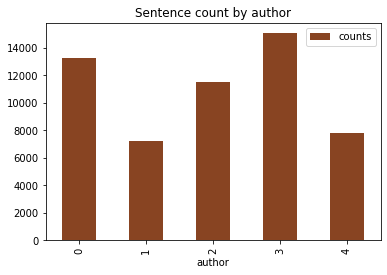

In [9]:
# 작가별 문장 수
train.groupby(train['author']).size().reset_index(name='counts').plot.bar(x='author', title='Sentence count by author', color='#884422')

In [10]:
train['author'].value_counts()

3    15063
0    13235
2    11554
4     7805
1     7222
Name: author, dtype: int64

C:\Users\GBJ\anaconda3\envs\tf240\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


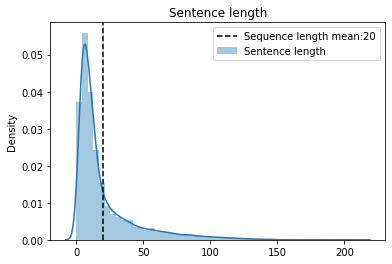

가장 긴 문장 내 단어의 수 : 211
가장 짧은 문장 내 단어의 수 : 0
평균 문장 내 단어의 수 : 20


In [11]:
# 공백으로 단어 길이를 계산한다.
train['sentence'] = train['text'].apply(lambda x : len(x.split()))

def plot_sentence_length(data):
    mean_seq_len = np.round(data['sentence'].mean()).astype(int)
    sns.distplot(tuple(data['sentence']), hist=True, kde=True, label='Sentence length')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Sentence length')
    plt.legend()
    plt.show()
    print(f"가장 긴 문장 내 단어의 수 : {train['sentence'].max()}")
    print(f"가장 짧은 문장 내 단어의 수 : {train['sentence'].min()}")
    print(f"평균 문장 내 단어의 수 : {mean_seq_len}")

plot_sentence_length(train)

# 2. Vectorization(Tokenization)

In [12]:
# ■■■■■■■■■■■■■■■■ Train, test data split(numpy) ■■■■■■■■■■■■■■■■
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
y_train = np.array([x for x in train['author']])

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(54879,)
(19617,)
(54879,)


In [14]:
X_train

array(['almost choking much much wanted say strange exclamations came lips pole gazed fixedly bundle notes hand looked odin evident perplexity',
       'sister asked suppose',
       'engaged one day walked perusing janes last letter dwelling passages proved jane not written spirits instead surprised mr odin saw looking odin meeting putting away letter immediately forcing smile said',
       ..., 'sincere wellwisher friend sister lucy odin',
       'wanted lend money', 'certainly not occurred said yes like'],
      dtype='<U1433')

In [15]:
X_test

array(['not think one charming young ladies ever met might useful work decided genius way witness way preserved agra plan papers father love emotional thing whatever emotional opposed true cold reason place things never marry lest bias judgment',
       'no replied sudden consciousness not find cannot ignorant goodness owe alli feel iti express couldbut well know no orator',
       'lady stated intention screaming course screamed additional boldness exertion rendered unnecessary hasty knocking door no sooner heard mr odin darted much agility wine bottles began dusting great violence matron sharply demanded',
       ...,
       'odin carried thanks odin proceeded happiness lucy excess time reached bartletts buildings able assure mrs odin called next day congratulations never seen spirits life',
       'soon upon odins leaving room mama said odin alarm subject illness cannot conceal sure odin not well now almost fortnight yet not come nothing real indisposition occasion extraordinary del

In [16]:
y_train

array([3, 2, 1, ..., 1, 3, 0])

In [17]:
# # ■■■■■■■■■■■■■■■■ Embedding ■■■■■■■■■■■■■■■■
freq_size = 2000
padding_type = 'post'

In [18]:
# Tokenizer는 데이터에 나오는 모든 단어의 수를 세고 빈도 수로 정렬한다.
# num_words에 입력한 만큼의 빈도 수를 반환한다.
tokenizer = Tokenizer(num_words=freq_size+1) #, oov_token="<OOV>")
# 문자 데이터를 입력받아서 리스트의 형태로 변환합니다.
tokenizer.fit_on_texts(X_train)

# 3. Embedding(+Pretrained model use)

In [19]:
# 단어는 (ex. {'apple':1, 'banana':2, ...}) 형태로 1부터 시작하는 dictionary를 반환합니다.
# 단어 대문자->소문자, 구두점(ex. 느낌표, 마침표)은 제거되어 인덱싱됩니다.
print(tokenizer.word_index['odin'])
print(tokenizer.word_index['treesapple'])
len(tokenizer.word_index)

1
47136


47136

In [20]:
vocab_size = len(tokenizer.word_index) + 1 #모델에 알려줄 vocabulary의 크기 계산
print('vocab_size : ', vocab_size)

vocab_size :  47137


In [21]:
# 텍스트 -> 시퀀스 변환(list)
# 위에서 fit_on_texts로 입력된 값(ex. X_train)에 토큰화되어있지 않는 단어를 넣으면 시퀀스에 포함되지 않는다!!!
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [22]:
print(len(train_sequences), len(test_sequences))

54879 19617


In [23]:
train_sequences[:2]

[[141, 20, 20, 316, 21, 229, 36, 452, 1202, 1701, 1207, 45, 57, 1, 1214],
 [217, 58, 221]]

In [24]:
test_sequences[:2]

[[2,
  23,
  5,
  1440,
  65,
  525,
  77,
  337,
  41,
  1791,
  252,
  849,
  43,
  1307,
  43,
  1121,
  653,
  117,
  133,
  105,
  555,
  236,
  358,
  277,
  114,
  182,
  25,
  655,
  1459],
 [4, 113, 434, 1391, 2, 146, 161, 1490, 279, 952, 12, 11, 4]]

In [25]:
# 문장 중에서 가장 길이가 긴 문장의 길이로 패딩을 처리할 것입니다.
max_len = max(len(l) for l in train_sequences)
print(f"시퀀스 처리된 문장 중 가장 긴 문장의 길이는 {max_len} 입니다.")

시퀀스 처리된 문장 중 가장 긴 문장의 길이는 160 입니다.


In [26]:
# 텍스트 길이 맞추기 padding(numpy)
# 서로 다른 개수의 단어로 이루어진 문장을 같은 길이로 만들기 위해 패딩을 사용한다.
# 상대적으로 길이가 짧은 문장을 긴 문장의 길이와 맞추기 위해 부족한 길이를 0으로 채운다.
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_len)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_len)

In [27]:
print(train_padded.shape, test_padded.shape)

(54879, 160) (19617, 160)


In [28]:
train_padded

array([[ 141,   20,   20, ...,    0,    0,    0],
       [ 217,   58,  221, ...,    0,    0,    0],
       [ 682,    5,   59, ...,    0,    0,    0],
       ...,
       [ 126,  217, 1670, ...,    0,    0,    0],
       [ 316,  164,    0, ...,    0,    0,    0],
       [ 203,    2,  811, ...,    0,    0,    0]])

In [29]:
test_padded

array([[   2,   23,    5, ...,    0,    0,    0],
       [   4,  113,  434, ...,    0,    0,    0],
       [ 120, 1244,  128, ...,    0,    0,    0],
       ...,
       [   1,  445, 1656, ...,    0,    0,    0],
       [ 109,    8,   19, ...,    0,    0,    0],
       [ 599,   10, 1696, ...,    0,    0,    0]])

In [30]:
# Pretrained model

# Word2Vec model
# word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

# fastText model
fastText_model = fasttext.load_model('word-embeddings/fasttext/fasttext.bin')

In [31]:
embedding_dim = 100

In [32]:
# 임베딩 값을 저장할 공간
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [33]:
def get_vector(word):
    if word in fastText_model:
        return fastText_model[word]
    else:
        return None

In [34]:
for word, i in tokenizer.word_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 값(value)를 temp에 저장
    if temp is not None: # 만약 temp가 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp # embedding_matrix의 해당 단어 위치의 행에 벡터의 값을 저장한다.

In [35]:
print(fastText_model['nice'])

[-0.04998829 -0.18253732 -0.27969757 -0.27977663  0.10857684  0.388294
  0.40117058  0.7248009  -0.28977823  0.5668249   0.32375613 -0.14560597
  0.6868329   0.3623459   0.46733359 -0.07494017  0.06123554 -0.02487937
  0.5860048   0.45586613 -0.3328445  -0.25034773 -0.4721855   0.14768477
 -0.18063433  0.95445687 -0.01118835 -0.09032692  0.67216605  0.0925161
  0.2856738   0.75324583 -0.5556388  -0.11671881 -0.33441705 -0.05370855
  0.03414882  0.3196702   0.05523127  0.04212253  0.03164786 -0.51626635
  0.55879927 -0.1895099  -0.3105072  -0.35776258  0.51512694 -0.47772348
 -0.67454195  0.25225025  0.36903894 -0.03699824  0.45187363 -0.48229814
 -0.60717225  0.1424689  -0.01876296 -0.67178136 -0.22196543 -0.9344287
 -0.6923644   0.65954566 -0.281638    0.16419232  0.29630715 -0.36719623
  0.69642925 -0.0860661  -0.31731993  0.41234097 -0.05776118  0.06376278
  0.00660518  0.0846712   0.6928425   0.10280303 -0.5902439  -0.30528638
 -0.38699368 -0.38289726 -0.29811007 -0.41951188  0.420

In [36]:
print('현재 단어 집합에서 단어 nice의 정수 인덱스 :', tokenizer.word_index['nice'])

현재 단어 집합에서 단어 nice의 정수 인덱스 : 1462


In [37]:
print(embedding_matrix[1462])

[-0.04998829 -0.18253732 -0.27969757 -0.27977663  0.10857684  0.38829401
  0.40117058  0.72480088 -0.28977823  0.56682491  0.32375613 -0.14560597
  0.6868329   0.3623459   0.46733359 -0.07494017  0.06123554 -0.02487937
  0.58600479  0.45586613 -0.3328445  -0.25034773 -0.47218549  0.14768477
 -0.18063433  0.95445687 -0.01118835 -0.09032692  0.67216605  0.0925161
  0.2856738   0.75324583 -0.55563879 -0.11671881 -0.33441705 -0.05370855
  0.03414882  0.3196702   0.05523127  0.04212253  0.03164786 -0.51626635
  0.55879927 -0.1895099  -0.31050721 -0.35776258  0.51512694 -0.47772348
 -0.67454195  0.25225025  0.36903894 -0.03699824  0.45187363 -0.48229814
 -0.60717225  0.1424689  -0.01876296 -0.67178136 -0.22196543 -0.93442869
 -0.69236439  0.65954566 -0.281638    0.16419232  0.29630715 -0.36719623
  0.69642925 -0.0860661  -0.31731993  0.41234097 -0.05776118  0.06376278
  0.00660518  0.0846712   0.69284248  0.10280303 -0.59024388 -0.30528638
 -0.38699368 -0.38289726 -0.29811007 -0.41951188  0.

In [38]:
# fastText_model의 nice라는 단어는 embedding_matrix에 인덱스 1462번으로 할당되어
# 실제 nice라는 벡터 값이 들어갔다.
# embedding_matrix는 학습 시, 가중치로 사용될 것이다.
fastText_model['nice'] == embedding_matrix[1462]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [39]:
embedding_matrix.shape

(47137, 100)

In [40]:
print(y_train)
print(y_train.shape)

[3 2 1 ... 1 3 0]
(54879,)


# 4. Model

In [ ]:
# ES = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

## 4-1. baseline 모델

In [46]:
# baseline
model_base = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [47]:
# Compile & Summary
model_base.compile(loss='sparse_categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

model_base.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 160, 100)          4713700   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                2424      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 125       
Total params: 4,716,249
Trainable params: 4,716,249
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Fit
history = model_base.fit(train_padded, y_train,
                         epochs=10, validation_split=0.2,
                         batch_size=128)

Epoch 1/10
343/343 [==============================] - 12s 33ms/step - loss: 1.5663 - accuracy: 0.2682 - val_loss: 1.5185 - val_accuracy: 0.3023
Epoch 2/10
343/343 [==============================] - 11s 33ms/step - loss: 1.4728 - accuracy: 0.3727 - val_loss: 1.2995 - val_accuracy: 0.4705
Epoch 3/10
343/343 [==============================] - 11s 31ms/step - loss: 1.2306 - accuracy: 0.5214 - val_loss: 1.0999 - val_accuracy: 0.5735
Epoch 4/10
343/343 [==============================] - 11s 31ms/step - loss: 1.0540 - accuracy: 0.5931 - val_loss: 1.0159 - val_accuracy: 0.6030
Epoch 5/10
343/343 [==============================] - 11s 31ms/step - loss: 0.9730 - accuracy: 0.6221 - val_loss: 0.9758 - val_accuracy: 0.6255
Epoch 6/10
343/343 [==============================] - 11s 31ms/step - loss: 0.9237 - accuracy: 0.6427 - val_loss: 0.9651 - val_accuracy: 0.6284
Epoch 7/10
343/343 [==============================] - 11s 31ms/step - loss: 0.8963 - accuracy: 0.6562 - val_loss: 0.9279 - val_accuracy:

In [49]:
loss, accuracy = model_base.evaluate(train_padded, y_train)

print('Accuracy: %f' % (accuracy * 100))
print('loss: %f' % (loss))

1715/1715 [==============================] - 4s 3ms/step - loss: 0.8118 - accuracy: 0.6894
Accuracy: 68.937117
loss: 0.811781


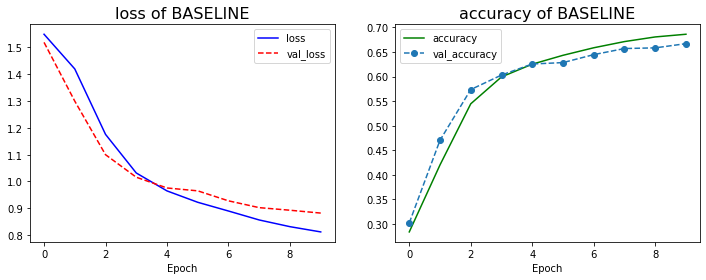

In [50]:
# ■■■■■■■■■■■■■■■■ Result visualization ■■■■■■■■■■■■■■■■
plt.figure(figsize=(12, 4))
plt.title('model', fontsize=16)

plt.subplot(1, 2, 1)
plt.title('loss of BASELINE', fontsize=16)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of BASELINE', fontsize=16)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'o--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [51]:
# predict values
pred = model_base.predict_proba(test_padded)

pred

C:\Users\GBJ\anaconda3\envs\tf240\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[6.8007773e-03, 9.4857401e-01, 1.9411450e-02, 2.4107359e-02,
        1.1063633e-03],
       [2.9616603e-01, 4.6029705e-01, 7.5212307e-02, 2.8460871e-02,
        1.3986364e-01],
       [8.5811090e-01, 7.7653127e-03, 8.4900651e-03, 9.5224101e-04,
        1.2468150e-01],
       ...,
       [1.4995631e-02, 9.8248601e-01, 1.3979996e-04, 1.5660027e-03,
        8.1258413e-04],
       [2.6918780e-03, 9.9189913e-01, 8.7321876e-04, 3.9997213e-03,
        5.3594203e-04],
       [4.1086215e-01, 5.0481739e-03, 4.9793032e-01, 2.3564701e-03,
        8.3802886e-02]], dtype=float32)

In [52]:
# submission
sample_submission[['0','1','2','3','4']] = pred
sample_submission

,index,0,1,2,3,4
0,0,0.006801,9.485740e-01,1.941145e-02,2.410736e-02,1.106363e-03
1,1,0.296166,4.602970e-01,7.521231e-02,2.846087e-02,1.398636e-01
2,2,0.858111,7.765313e-03,8.490065e-03,9.522410e-04,1.246815e-01
3,3,0.005789,5.455258e-07,8.694688e-01,1.473806e-08,1.247417e-01
4,4,0.514076,1.850511e-01,5.456523e-02,9.891015e-02,1.473972e-01
...,...,...,...,...,...,...
19612,19612,0.000109,9.998912e-01,1.068238e-09,4.169297e-08,7.078897e-09
19613,19613,0.092419,5.769578e-05,2.297994e-02,9.060328e-07,8.845426e-01
19614,19614,0.014996,9.824860e-01,1.398000e-04,1.566003e-03,8.125841e-04
19615,19615,0.002692,9.918991e-01,8.732188e-04,3.999721e-03,5.359420e-04


In [53]:
sample_submission.to_csv('submission/submission_baseline.csv', index = False, encoding = 'utf-8')

## 4-2. LSTM 모델

In [65]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len),
    tf.keras.layers.LSTM(units=256, return_sequences=True),
    tf.keras.layers.LSTM(units=128, return_sequences=True),
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [66]:
# Compile & Summary
model_lstm.compile(loss='sparse_categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 160, 100)          4713700   
_________________________________________________________________
lstm_7 (LSTM)                (None, 160, 256)          365568    
_________________________________________________________________
lstm_8 (LSTM)                (None, 160, 128)          197120    
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 325       
Total params: 5,326,121
Trainable params: 5,326,121
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Fit
history = model_lstm.fit(train_padded, y_train,
                         epochs=10, validation_split=0.2,
                         batch_size=128)

Epoch 1/10
343/343 [==============================] - 30s 74ms/step - loss: 1.5734 - accuracy: 0.2798 - val_loss: 1.5710 - val_accuracy: 0.2680
Epoch 2/10
343/343 [==============================] - 24s 71ms/step - loss: 1.5728 - accuracy: 0.2731 - val_loss: 1.5734 - val_accuracy: 0.2680
Epoch 3/10
343/343 [==============================] - 24s 69ms/step - loss: 1.5709 - accuracy: 0.2774 - val_loss: 1.5714 - val_accuracy: 0.2680
Epoch 4/10
343/343 [==============================] - 24s 70ms/step - loss: 1.5693 - accuracy: 0.2783 - val_loss: 1.5712 - val_accuracy: 0.2680
Epoch 5/10
343/343 [==============================] - 24s 70ms/step - loss: 1.5722 - accuracy: 0.2746 - val_loss: 1.5714 - val_accuracy: 0.2680
Epoch 6/10
343/343 [==============================] - 24s 70ms/step - loss: 1.5704 - accuracy: 0.2757 - val_loss: 1.5713 - val_accuracy: 0.2680
Epoch 7/10
343/343 [==============================] - 24s 70ms/step - loss: 1.5667 - accuracy: 0.2773 - val_loss: 1.5717 - val_accuracy:

In [68]:
loss, accuracy = model_lstm.evaluate(train_padded, y_train)

print('Accuracy: %f' % (accuracy * 100))
print('loss: %f' % (loss))

1715/1715 [==============================] - 24s 14ms/step - loss: 1.5703 - accuracy: 0.2745
Accuracy: 27.447659
loss: 1.570307


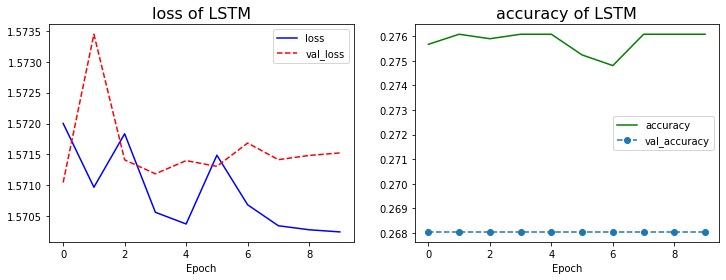

In [69]:
# ■■■■■■■■■■■■■■■■ Result visualization ■■■■■■■■■■■■■■■■
plt.figure(figsize=(12, 4))
plt.title('model', fontsize=16)

plt.subplot(1, 2, 1)
plt.title('loss of LSTM', fontsize=16)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of LSTM', fontsize=16)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'o--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [70]:
# predict values
pred = model_lstm.predict_proba(test_padded)

pred

C:\Users\GBJ\anaconda3\envs\tf240\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[0.2405051 , 0.12746708, 0.21133037, 0.280019  , 0.14067845],
       [0.2405051 , 0.12746708, 0.21133037, 0.280019  , 0.14067845],
       [0.2405051 , 0.12746708, 0.21133037, 0.280019  , 0.14067845],
       ...,
       [0.2405051 , 0.12746708, 0.21133037, 0.280019  , 0.14067845],
       [0.2405051 , 0.12746708, 0.21133037, 0.280019  , 0.14067845],
       [0.2405051 , 0.12746708, 0.21133037, 0.280019  , 0.14067845]],
      dtype=float32)

In [71]:
# submission
sample_submission[['0','1','2','3','4']] = pred
sample_submission

,index,0,1,2,3,4
0,0,0.240505,0.127467,0.21133,0.280019,0.140678
1,1,0.240505,0.127467,0.21133,0.280019,0.140678
2,2,0.240505,0.127467,0.21133,0.280019,0.140678
3,3,0.240505,0.127467,0.21133,0.280019,0.140678
4,4,0.240505,0.127467,0.21133,0.280019,0.140678
...,...,...,...,...,...,...
19612,19612,0.240505,0.127467,0.21133,0.280019,0.140678
19613,19613,0.240505,0.127467,0.21133,0.280019,0.140678
19614,19614,0.240505,0.127467,0.21133,0.280019,0.140678
19615,19615,0.240505,0.127467,0.21133,0.280019,0.140678


In [72]:
sample_submission.to_csv('submission/submission_lstm.csv', index = False, encoding = 'utf-8')

## 4-3. 양방향 LSTM 모델

In [73]:
model_bilstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [74]:
# Compile & Summary
model_bilstm.compile(loss='sparse_categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

model_bilstm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 160, 100)          4713700   
_________________________________________________________________
bidirectional (Bidirectional (None, 160, 256)          234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 160, 128)          164352    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 645       
Total params: 5,212,009
Trainable params: 5,212,009
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Fit
history = model_bilstm.fit(train_padded, y_train,
                    epochs=10, validation_split=0.2,
                    batch_size=128)

Epoch 1/10
343/343 [==============================] - 55s 135ms/step - loss: 1.4338 - accuracy: 0.3617 - val_loss: 1.0522 - val_accuracy: 0.5900
Epoch 2/10
343/343 [==============================] - 49s 143ms/step - loss: 0.9794 - accuracy: 0.6151 - val_loss: 0.9390 - val_accuracy: 0.6310
Epoch 3/10
343/343 [==============================] - 48s 141ms/step - loss: 0.8472 - accuracy: 0.6724 - val_loss: 0.8675 - val_accuracy: 0.6680
Epoch 4/10
343/343 [==============================] - 48s 141ms/step - loss: 0.7873 - accuracy: 0.6962 - val_loss: 0.8643 - val_accuracy: 0.6675
Epoch 5/10
343/343 [==============================] - 49s 142ms/step - loss: 0.7575 - accuracy: 0.7053 - val_loss: 0.9133 - val_accuracy: 0.6472
Epoch 6/10
343/343 [==============================] - 49s 142ms/step - loss: 0.7225 - accuracy: 0.7226 - val_loss: 0.8635 - val_accuracy: 0.6698
Epoch 7/10
343/343 [==============================] - 49s 143ms/step - loss: 0.7097 - accuracy: 0.7260 - val_loss: 0.8687 - val_ac

In [76]:
loss, accuracy = model_bilstm.evaluate(train_padded, y_train)

print('Accuracy: %f' % (accuracy * 100))
print('loss: %f' % (loss))

1715/1715 [==============================] - 37s 21ms/step - loss: 0.6577 - accuracy: 0.7539
Accuracy: 75.385851
loss: 0.657722


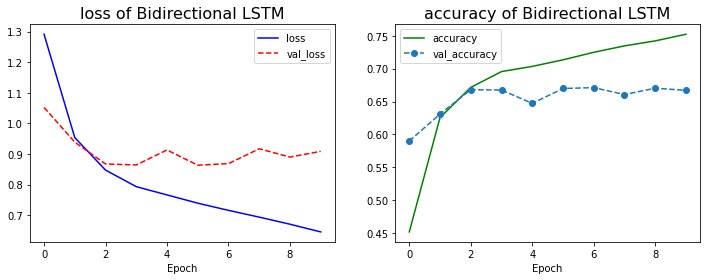

In [77]:
# ■■■■■■■■■■■■■■■■ Result visualization ■■■■■■■■■■■■■■■■
plt.figure(figsize=(12, 4))
plt.title('model', fontsize=16)

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM', fontsize=16)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM', fontsize=16)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'o--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [78]:
# predict values
pred = model_bilstm.predict_proba(test_padded)

pred

C:\Users\GBJ\anaconda3\envs\tf240\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[2.0266592e-03, 9.9591172e-01, 5.4164982e-04, 1.3391390e-03,
        1.8079228e-04],
       [1.3912708e-01, 1.2507026e-01, 2.2549045e-03, 1.6028692e-03,
        7.3194486e-01],
       [9.8244321e-01, 1.2851013e-03, 2.2057905e-03, 1.3550476e-03,
        1.2710922e-02],
       ...,
       [8.9483970e-04, 9.9884254e-01, 7.4460004e-05, 8.7449465e-05,
        1.0073505e-04],
       [6.0545868e-04, 9.9889451e-01, 1.1181838e-04, 2.8669683e-04,
        1.0141062e-04],
       [6.2436229e-01, 2.6652604e-02, 3.0308515e-01, 2.8876577e-02,
        1.7023373e-02]], dtype=float32)

In [79]:
# submission
sample_submission[['0','1','2','3','4']] = pred
sample_submission

,index,0,1,2,3,4
0,0,0.002027,0.995912,0.000542,0.001339,0.000181
1,1,0.139127,0.125070,0.002255,0.001603,0.731945
2,2,0.982443,0.001285,0.002206,0.001355,0.012711
3,3,0.021249,0.030470,0.940024,0.000700,0.007558
4,4,0.082036,0.406952,0.006271,0.017666,0.487075
...,...,...,...,...,...,...
19612,19612,0.000854,0.998745,0.000112,0.000156,0.000134
19613,19613,0.355716,0.001547,0.009448,0.002386,0.630903
19614,19614,0.000895,0.998843,0.000074,0.000087,0.000101
19615,19615,0.000605,0.998895,0.000112,0.000287,0.000101


In [80]:
sample_submission.to_csv('submission/submission_bilstm.csv', index = False, encoding = 'utf-8')

## 4-4. CNN 모델

In [100]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [101]:
# Compile & Summary
model_cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 160, 100)          4713700   
_________________________________________________________________
dropout_58 (Dropout)         (None, 160, 100)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 160, 256)          77056     
_________________________________________________________________
global_max_pooling1d_27 (Glo (None, 256)               0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_60 (Dropout)         (None, 128)             

In [103]:
# Fit
history = model_cnn.fit(train_padded, y_train,
                        epochs=10, validation_split=0.2,
                        batch_size=128)

Epoch 1/10
343/343 [==============================] - 11s 33ms/step - loss: 1.5002 - accuracy: 0.3361 - val_loss: 1.3547 - val_accuracy: 0.4268
Epoch 2/10
343/343 [==============================] - 11s 32ms/step - loss: 1.3100 - accuracy: 0.4532 - val_loss: 1.1980 - val_accuracy: 0.5199
Epoch 3/10
343/343 [==============================] - 11s 31ms/step - loss: 1.1954 - accuracy: 0.5101 - val_loss: 1.1150 - val_accuracy: 0.5636
Epoch 4/10
343/343 [==============================] - 11s 31ms/step - loss: 1.1244 - accuracy: 0.5460 - val_loss: 1.0623 - val_accuracy: 0.5832
Epoch 5/10
343/343 [==============================] - 11s 31ms/step - loss: 1.0781 - accuracy: 0.5725 - val_loss: 1.0250 - val_accuracy: 0.6021
Epoch 6/10
343/343 [==============================] - 11s 33ms/step - loss: 1.0402 - accuracy: 0.5896 - val_loss: 1.0032 - val_accuracy: 0.6117
Epoch 7/10
343/343 [==============================] - 11s 32ms/step - loss: 1.0133 - accuracy: 0.6001 - val_loss: 0.9866 - val_accuracy:

In [104]:
loss, accuracy = model_cnn.evaluate(train_padded, y_train)

print('Accuracy: %f' % (accuracy * 100))
print('loss: %f' % (loss))

1715/1715 [==============================] - 6s 3ms/step - loss: 0.8746 - accuracy: 0.6697
Accuracy: 66.974616
loss: 0.874578


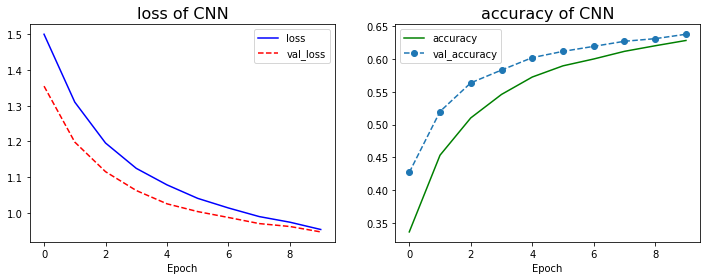

In [105]:
# ■■■■■■■■■■■■■■■■ Result visualization ■■■■■■■■■■■■■■■■
plt.figure(figsize=(12, 4))
plt.title('model', fontsize=16)

plt.subplot(1, 2, 1)
plt.title('loss of CNN', fontsize=16)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of CNN', fontsize=16)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'o--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [106]:
# predict values
pred = model_cnn.predict_proba(test_padded)

pred

C:\Users\GBJ\anaconda3\envs\tf240\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


array([[1.17161304e-01, 4.57536250e-01, 1.17474884e-01, 2.94251680e-01,
        1.35758771e-02],
       [2.84017205e-01, 3.00845325e-01, 6.21507019e-02, 4.19248119e-02,
        3.11062008e-01],
       [6.79204762e-01, 9.93819814e-03, 2.55447309e-02, 8.83708429e-03,
        2.76475191e-01],
       ...,
       [1.45669444e-03, 9.98533130e-01, 2.76809374e-07, 9.43790837e-06,
        3.73423489e-07],
       [1.19954981e-01, 7.04325378e-01, 8.06543827e-02, 6.61901906e-02,
        2.88750492e-02],
       [3.05116147e-01, 2.83107106e-02, 2.78219938e-01, 2.15039253e-01,
        1.73314005e-01]], dtype=float32)

In [107]:
# submission
sample_submission[['0','1','2','3','4']] = pred
sample_submission

,index,0,1,2,3,4
0,0,0.117161,0.457536,1.174749e-01,0.294252,1.357588e-02
1,1,0.284017,0.300845,6.215070e-02,0.041925,3.110620e-01
2,2,0.679205,0.009938,2.554473e-02,0.008837,2.764752e-01
3,3,0.098128,0.005909,3.578109e-01,0.015522,5.226294e-01
4,4,0.210051,0.210547,2.573083e-01,0.243686,7.840759e-02
...,...,...,...,...,...,...
19612,19612,0.010552,0.987607,7.897153e-05,0.001700,6.222130e-05
19613,19613,0.275312,0.031842,2.626926e-01,0.002801,4.273527e-01
19614,19614,0.001457,0.998533,2.768094e-07,0.000009,3.734235e-07
19615,19615,0.119955,0.704325,8.065438e-02,0.066190,2.887505e-02


In [108]:
sample_submission.to_csv('submission/submission_cnn.csv', index = False, encoding = 'utf-8')

# 참고
딥 러닝을 이용한 자연어 처리 입문 https://wikidocs.net/book/2155
<br>
Codetorial https://codetorial.net/tensorflow/index.html
<br>
Keras Documentation https://keras.io/

# ※ 밑에는 안씁니다. ※

## 테스트 CNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
# Compile & Summary
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

In [ ]:
# Fit
history = model.fit(train_padded, y_train,
                    epochs=30, validation_split=0.2,
                    batch_size=128,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')])